# Evaluation Notebook

In [14]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.tools import load_config

In [ ]:
data = 'synth_wind'

config = load_config('config.yaml')
results_dir = config['eval']['results_path']
results_dir = os.path.join(results_dir, data)
result_files = os.listdir(results_dir)
# pickle files where training was performed on single dataset sequentially
sims = [f for f in result_files if (f.endswith('.pkl')) & ('cl' not in f) & ('fl' not in f)]
# pickle files where training was performed on concatenated datasets (centralized learning)
cl_sims = [f for f in result_files if 'cl' in f]
# pickle files for federated learning simulations
fl_sims = [f for f in result_files if 'fl' in f]
persistence_file = [f for f in result_files if 'persistence' in f]
if persistence_file:
    persistence_file = persistence_file[0]

In [ ]:
def concatenate_results(results_dir: str,
                        results: list,
                        index_cols: list,
                        get_skill: bool = False,
                        pers: pd.DataFrame = pd.DataFrame(),
                        sort_skill: bool = False) -> pd.DataFrame:
    indices = defaultdict(list)
    metrics = []
    if not results:
        print('No data found.')
        return None
    # initialize the dict list
    for file in results:  # Iterate through all result files
        # Load the data
        with open(os.path.join(results_dir, file), 'rb') as f:
            pkl = pickle.load(f)
        df = pkl['evaluation']
        df.reset_index(inplace=True)
        if get_skill:
            df= pd.merge(df, pers[['RMSE', 'key', 'output_dim', 'freq']],
               on=['key', 'output_dim', 'freq'],
               how='left',
               suffixes=('', '_p'))
            df['Skill'] = 1 - df.RMSE / df.RMSE_p
            df.drop('RMSE_p', axis=1, inplace=True)
        for col in index_cols:
            indices[col].append(df[col].iloc[0])
        df.drop(index_cols, axis=1, inplace=True)
        if len(df) != 1:
            df.drop('key', axis=1, inplace=True)
        metric = df.mean(axis=0)
        metrics.append(metric)
    df = pd.DataFrame(metrics, columns=metric.index)
    df_index = pd.DataFrame(indices)
    df = pd.concat([df, df_index], axis=1)
    df.sort_values(['output_dim', 'freq', 'Models'], inplace=True)
    if sort_skill:
        df.sort_values(['Skill'], ascending=False, inplace=True)
    return df

def read_sim(results_dir, sim):
    try:
        with open(os.path.join(results_dir, sim), 'rb') as f:
            sim_results = pickle.load(f)
    except:
        sim_results = None
    return sim_results

In [5]:
pers = pd.read_csv(os.path.join(results_dir, persistence_file))

TypeError: join() argument must be str, bytes, or os.PathLike object, not 'list'

Local simulation analysis - 1 dataset : 1 model 

In [6]:
index_cols = ['Models', 'output_dim', 'freq', 't_0']
df_sep = concatenate_results(results_dir=results_dir, results=sims, index_cols=index_cols)
df_sep[['R^2', 'RMSE', 'MAE', 'Skill', 'Models']].round(4).set_index('Models')

I0000 00:00:1748939048.229131 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46209 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748939048.232087 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46683 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
I0000 00:00:1748939048.234760 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46731 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1748939048.237394 1375615 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46717 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1748939048.240031 1375615 gpu_device.cc:2022] Created device /job:localh

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.8103,0.117,0.0765,0.241


Federated simulation analysis - N datasets : 1 model

In [6]:
index_cols = ['Models', 'output_dim', 'freq', 't_0', 'strategy', 'personalization']
df_fl = concatenate_results(results_dir=results_dir,
                            results=fl_sims,
                            index_cols=index_cols)
df_fl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models', 'strategy', 'personalization']].round(4).set_index('Models')

,R^2,RMSE,MAE,Skill,strategy,personalization
Models,,,,,,
tcn-gru,0.956,0.0309,0.0161,0.6575,fedavg,False


Centralized simulation analysis - N datasets : 1 model

In [13]:
index_cols = ['Models', 'output_dim', 'freq', 't_0', 'key']
df_cl = concatenate_results(results_dir=results_dir,
                             get_skill=False,
                             #pers=pers,
                             results=cl_sims,
                             index_cols=index_cols)
df_cl[['R^2', 'RMSE', 'MAE', 'Skill', 'Models', 'output_dim', 'key']].round(4).set_index('Models')

1
Index(['R^2', 'RMSE', 'MAE', 'Skill'], dtype='object')


,R^2,RMSE,MAE,Skill,output_dim,key
Models,,,,,,
lstm,0.7856,0.9686,0.7459,0.5394,12,00198.csv


Individual simulation analysis

In [ ]:
model = 'tcn-gru'
output_dim = 48
freq = '1h'
strategy = 'fedavg'
gti = '_pers'

fontsize = 12

sim = f'd-{data}_m-{model}_out-{output_dim}_freq-{freq}.pkl'
cl_sim = f'cl_d-{data}_m-{model}_out-48_freq-{freq}.pkl'
fl_sim = f'fl_a-{strategy}_d-{data}_m-{model}_out-{output_dim}_freq-{freq}{gti}.pkl'

In [29]:
sim_results = read_sim(results_dir, sim)
cl_results = read_sim(results_dir, cl_sim)
fl_results = read_sim(results_dir, fl_sim)

In [8]:
sim_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

TypeError: 'NoneType' object is not subscriptable

In [9]:
fl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
station00.csv,0.9320,0.0597,0.0239,0.5601
station01.csv,0.9709,0.0519,0.0303,0.6646
station02.csv,0.9773,0.0388,0.0228,0.7357
station04.csv,0.9668,0.0700,0.0412,0.7133
station06.csv,0.9588,0.0431,0.0247,0.6057
station07.csv,0.9625,0.0478,0.0242,0.6704
station08.csv,0.9834,0.0324,0.0192,0.7807


In [12]:
fig = plt.figure(figsize=(10, 5))

plt.plot(fl_results['history']['metrics_aggregated']['train_loss'], label='train_loss')
plt.plot(fl_results['history']['metrics_aggregated']['eval_loss'], label='val_loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x360 with 0 Axes>

In [42]:
cl_results['evaluation'][['R^2', 'RMSE', 'MAE', 'Skill', 'key']].round(4).set_index('key')

,R^2,RMSE,MAE,Skill
key,,,,
pvpark_5.csv,0.9108,0.0422,0.0246,0.4888
pvpark_1.csv,0.8872,0.0498,0.0287,0.3939
pvpark_3.csv,0.8855,0.0526,0.0307,0.4968
pvpark_2.csv,0.9125,0.0428,0.0254,0.4848
pvpark_4.csv,0.9121,0.0386,0.0228,0.4702


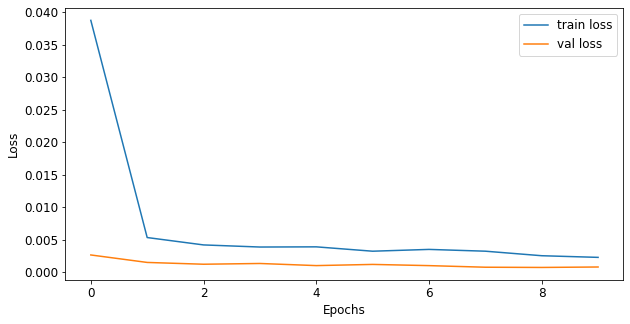

In [21]:
fig = plt.figure(figsize=(10, 5))

plt.plot(cl_results['history']['loss'], label='train loss')
plt.plot(cl_results['history']['val_loss'], label='val loss')
plt.xlabel('Epochs', size=fontsize)
plt.ylabel('Loss', size=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()